# **DLIP Tutorial - PyTorch**
# Part 1: Inference using pre-trained model (classification)

Y.-K. Kim  (updated 2024. 5. 9)

classification model using a pretrained CNN model provided by PyTorch
 
 The models were pre-trained on the **ImageNet** dataset (1000 classes)


## For CoLab Usage:

1. First, download this notebook
2. Then, open in Colab

# Preparation

In [ ]:
import torch
from torchvision import transforms
from torchvision import models
from torchsummary import summary

import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image

### GPU Setting

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 

Using cuda device
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


# Load a pre-trained model from TorchVision


Let’s import models from torchvision module and see what are the different models and architectures available with us. (see: https://pytorch.org/vision/stable/models.html)

In [4]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

Notice that there is one entry called AlexNet and one called alexnet. The capitalised name refers to the Python class (AlexNet) whereas alexnet is a convenience function that returns the model instantiated from the AlexNet class. These convenience functions can have different parameter sets. 

Densenet121, densenet161, densenet169, densenet201, all are instances of DenseNet class but with a different number of layers – 121,161,169 and 201, respectively.

### Load Pretrained VGG-16
We will use VGG-16 for this tutorial.  Check the model architecture using summary

In [5]:
model = models.vgg16(pretrained=True)
model.eval() # run the model with evaluation mode
model = model.cuda()

summary(model, (3, 224, 224))

c:\Users\Sangheon\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sangheon\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Test image preparation

In this tutorial, we load one test image file from the following URL

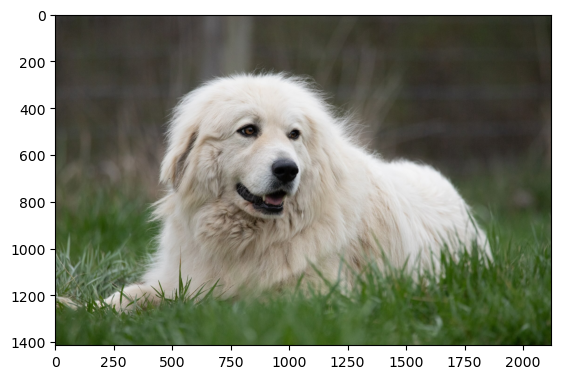

In [6]:
# Download an example image from URL
# url = "https://3.bp.blogspot.com/-W__wiaHUjwI/Vt3Grd8df0I/AAAAAAAAA78/7xqUNj8ujtY/s1600/image02.png"
url = "https://pet-health-content-media.chewy.com/wp-content/uploads/2025/03/21152834/white-great-pyrenees.jpg"
filename = "test_image.jpg"

import urllib
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# image show

# from google.colab.patches import cv2_imshow
# img = cv.imread(filename)
# cv2_imshow(img)
img = cv.imread(filename)
dst = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(dst)
plt.show()


# Inference using pretrained model

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Here's a sample execution. 

The output is the probability value for each 1000 classes. (the sum of all probabilities is 1)

In [8]:
# sample execution (requires torchvision)
# Normalize and resize to 224x224
input_image = Image.open(filename)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Forward process
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([1.4937e-08, 6.3732e-10, 3.1162e-08, 3.2046e-09, 1.0866e-09, 3.7833e-09,
        1.4151e-09, 1.2692e-08, 4.0604e-08, 1.0602e-08, 2.3450e-09, 4.6490e-09,
        2.5233e-09, 3.7511e-09, 3.2539e-09, 3.7723e-09, 2.4533e-09, 3.0590e-09,
        9.0161e-09, 8.0098e-09, 1.4680e-08, 1.6128e-08, 2.1119e-07, 6.9311e-08,
        2.3482e-07, 1.1626e-08, 1.2787e-09, 2.6074e-09, 1.5152e-08, 5.8622e-10,
        2.3354e-09, 8.2241e-09, 3.6829e-09, 6.1165e-09, 6.1606e-09, 2.6372e-09,
        1.2800e-08, 3.4960e-09, 2.0847e-10, 4.6434e-09, 2.9781e-09, 1.1141e-09,
        4.6575e-10, 6.8797e-10, 7.9700e-10, 7.0554e-09, 4.2475e-09, 5.5979e-10,
        1.1394e-08, 1.9502e-08, 6.3906e-08, 5.1559e-09, 8.9705e-09, 7.1772e-09,
        7.3117e-10, 7.7980e-09, 6.3261e-10, 3.4564e-09, 2.5192e-09, 5.2615e-09,
        2.1008e-08, 1.3476e-09, 8.0658e-09, 2.1136e-09, 3.8165e-09, 1.0401e-08,
        2.5534e-09, 5.2535e-09, 2.1868e-09, 2.2727e-09, 7.6749e-09, 4.4282e-09,
        2.2227e-08, 1.0501e-08, 1.7426e-

What do we do with the output which is a vector with 1000 elements? We need to get class label list of the image. 

Thus, we will load label information from a text file having a list of all the 1000 class labels. The line number specifies the class number

In [9]:
# Download ImageNet labels
import urllib
url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
filename = 'imagenet_classes.txt'
urllib.request.urlretrieve(url, filename)

('imagenet_classes.txt', <http.client.HTTPMessage at 0x23e70562ee0>)

Now, we need to find out the index for the maximum probability. This index is the prediction class.
For this tutorial, we will print the top-5 probability

In [10]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top 5 categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Great Pyrenees 0.804245114326477
Tibetan mastiff 0.0910443440079689
kuvasz 0.062017492949962616
Tibetan terrier 0.010056382045149803
Newfoundland 0.009518058970570564
